In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


#EDA &amp; Dataset Preparation

In [3]:
# Normalize the pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [4]:
# Check the shapes of the dataset
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", x_test.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


In [5]:
# Plot sample images
def plot_sample_images(images, labels, num=10):
    plt.figure(figsize=(15, 5))
    for i in range(num):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i][0]}')
        plt.axis("off")
    plt.show()

Sample Images from CIFAR-10 Training Set:


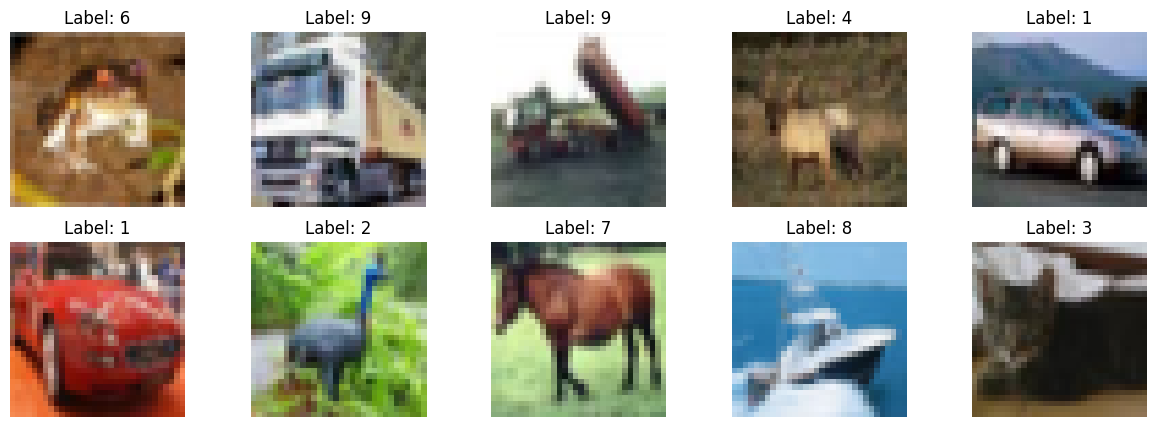

In [6]:
# Display some sample images from the training set
print("Sample Images from CIFAR-10 Training Set:")
plot_sample_images(x_train, y_train, num=10)

In [7]:
# Check the unique classes
unique_classes = np.unique(y_train)
print("Unique classes in the dataset:", unique_classes)

Unique classes in the dataset: [0 1 2 3 4 5 6 7 8 9]


In [8]:
# use the class names instead of numerical labels
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

In [9]:
# Display the class names
for i in unique_classes:
    print(f'Class {i}: {class_names[i]}')

Class 0: airplane
Class 1: automobile
Class 2: bird
Class 3: cat
Class 4: deer
Class 5: dog
Class 6: frog
Class 7: horse
Class 8: ship
Class 9: truck


#Model Implementation &amp; Fine-Tuning

In [10]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Lambda, MaxPooling2D, Conv2DTranspose, UpSampling2D, Layer
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Model

In [11]:
# Sampling function for VAE
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
# Custom VAE loss layer with weighted KL divergence
class VAELossLayer(Layer):
    def __init__(self, kl_weight=0.1, **kwargs):  # Add weight parameter for KL loss
        super(VAELossLayer, self).__init__(**kwargs)
        self.kl_weight = kl_weight  # Weight factor for KL divergence

    def call(self, inputs):
        input_img, decoded, z_mean, z_log_var = inputs

        # Reconstruction loss (Mean Squared Error)
        reconstruction_loss = tf.reduce_mean(tf.square(input_img - decoded))

        # KL divergence loss with weight factor
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
        total_loss = reconstruction_loss + self.kl_weight * kl_loss  # Weighted KL divergence

        self.add_loss(total_loss)
        return decoded

In [13]:
# Define Variational Autoencoder (VAE) using Functional API
def build_variational_autoencoder():
    input_img = Input(shape=(32, 32, 3))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Flatten and create the mean and log variance vectors for the latent space
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    z_mean = Dense(128)(x)
    z_log_var = Dense(128)(x)

    # Sample from the latent space
    z = Lambda(sampling, output_shape=(128,), name='z')([z_mean, z_log_var])

    # Decoder
    decoder_h = Dense(8 * 8 * 64, activation='relu')(z)
    x = Reshape((8, 8, 64))(decoder_h)
    x = Conv2DTranspose(64, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(32, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    # VAE loss layer
    vae_output = VAELossLayer()([input_img, decoded, z_mean, z_log_var])

    # Define the VAE model
    vae = Model(input_img, vae_output)

    vae.compile(optimizer='adam')

    return vae

In [14]:
# Instantiate and compile the variational autoencoder
vae = build_variational_autoencoder()
vae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 64)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 4096)           │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      1,048,832 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 128)            │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4096)           │        528,384 │ z[0][0]                │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 8, 8, 64)       │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 8, 8, 64)       │        102,464 │ reshape[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 16, 64)     │              0 │ conv2d_transpose[0][0] │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 16, 16, 32)     │         51,232 │ up_sampling2d[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_transpose_1[0]… │
│ (UpSampling2D)            │                        │                │                        │
├──────────────────────

 Total params: 1,816,963 (6.93 MB)

 Trainable params: 1,816,963 (6.93 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the Variational Autoencoder
history_vae = vae.fit(
    x_train, x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.0550 - val_loss: 0.0422
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0401 - val_loss: 0.0359
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0354 - val_loss: 0.0344
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0342 - val_loss: 0.0339
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0338 - val_loss: 0.0336
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0333 - val_loss: 0.0332
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0332 - val_loss: 0.0332
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0332 - val_loss: 0.0331
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0330 - val_loss: 0.0327
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0329 - val_loss: 0.0326
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0327 - val_loss: 0.0326
Epoch 12/20
391/391 ━━━━━━━━━━━━━━━━━━━━

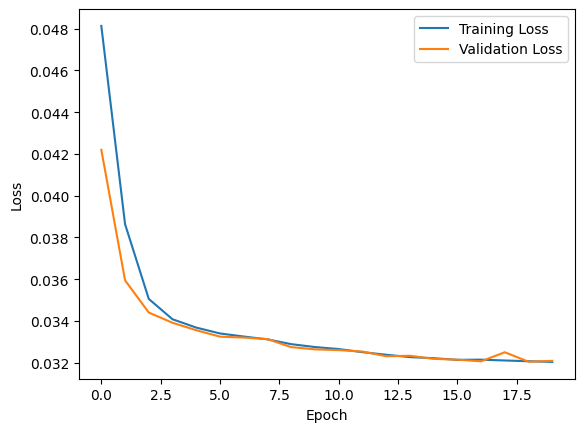

In [16]:
# Plot training and validation loss
plt.plot(history_vae.history['loss'], label='Training Loss')
plt.plot(history_vae.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Function to display original and reconstructed images
def display_reconstructed_images(autoencoder, images, num_images=10):
    reconstructed_images = autoencoder.predict(images[:num_images])
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original image
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed image
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

Original vs. Reconstructed Images (Variational Autoencoder):
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


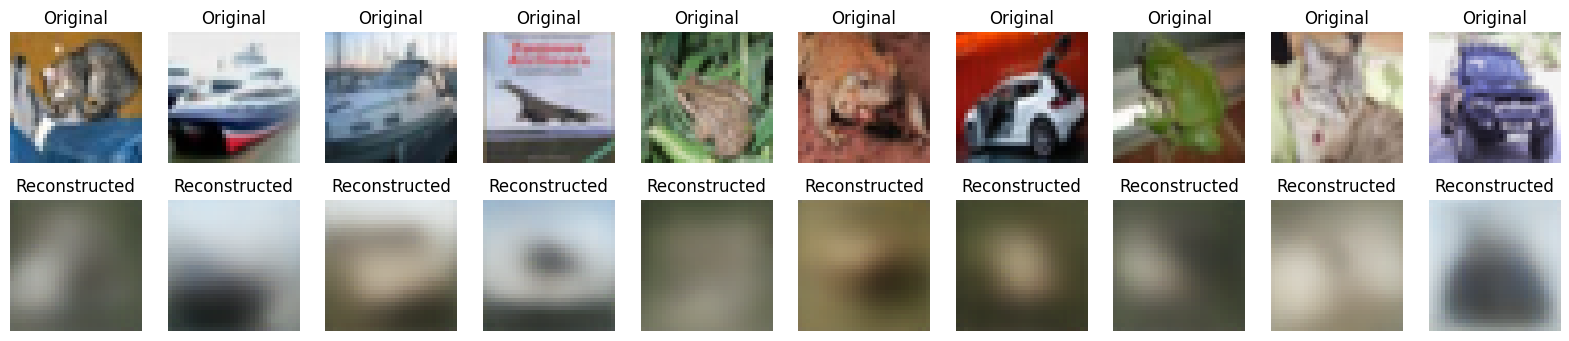

In [18]:
# Display original and reconstructed images from the test set
print("Original vs. Reconstructed Images (Variational Autoencoder):")
display_reconstructed_images(vae, x_test)

#Model Evaluation &amp; Comparative Analysis

##Reconstruction Quality Using Performance Metrics

####Reconstruction Loss and Mean Square Error (MSE)

In [20]:
from sklearn.metrics import mean_squared_error
import time

# Compute reconstruction loss on test data
reconstruction_loss = vae.evaluate(x_test, x_test, verbose=0)

# Compute Mean Squared Error (MSE) for the reconstructed images
reconstructed_images = vae.predict(x_test)
mse_list = [mean_squared_error(x_test[i].flatten(), reconstructed_images[i].flatten()) for i in range(len(x_test))]
mean_mse = np.mean(mse_list)

print(f"Reconstruction Loss (Binary Crossentropy): {reconstruction_loss:.4f}")
print(f"Mean Squared Error (MSE): {mean_mse:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Reconstruction Loss (Binary Crossentropy): 0.0321
Mean Squared Error (MSE): 0.0242


##Efficiency

####Measure Inference Time

In [21]:
# Measure inference time for a batch of 100 images
num_samples = 100
sample_images = x_test[:num_samples]

start_time = time.time()
_ = vae.predict(sample_images)
end_time = time.time()

inference_time = (end_time - start_time) / num_samples
print(f"Average Inference Time per Image: {inference_time:.6f} seconds")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
Average Inference Time per Image: 0.013137 seconds


####Measure Memory Usage

In [22]:
import tracemalloc

# Start tracing memory allocation
tracemalloc.start()

# Perform inference
_ = vae.predict(sample_images)

# Get the current memory usage
current, peak = tracemalloc.get_traced_memory()
print(f"Current Memory Usage: {current / 10**6:.2f} MB")
print(f"Peak Memory Usage: {peak / 10**6:.2f} MB")

# Stop tracing
tracemalloc.stop()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Current Memory Usage: 1.32 MB
Peak Memory Usage: 1.36 MB


####Compile Results into a Report

In [23]:
from tabulate import tabulate

# Prepare results for Variational Autoencoder
results = [
    ["Reconstruction Loss (Binary Crossentropy)", reconstruction_loss],
    ["Mean Squared Error (MSE)", mean_mse],
    ["Average Inference Time per Image (s)", inference_time],
    ["Peak Memory Usage (MB)", peak / 10**6]
]

# Print results in a table format
print(tabulate(results, headers=["Metric", "Value"], tablefmt="grid"))

+-------------------------------------------+-----------+
| Metric                                    |     Value |
+===========================================+===========+
| Reconstruction Loss (Binary Crossentropy) | 0.0321149 |
+-------------------------------------------+-----------+
| Mean Squared Error (MSE)                  | 0.0242334 |
+-------------------------------------------+-----------+
| Average Inference Time per Image (s)      | 0.0131369 |
+-------------------------------------------+-----------+
| Peak Memory Usage (MB)                    | 1.35711   |
+-------------------------------------------+-----------+
